# SciPy
![SciPy](https://raw.githubusercontent.com/scipy/scipy-sphinx-theme/master/_static/scipyshiny_small.png)

- Uses numpy as its core
- Numerical methods for:
    + integration
    + solving differential equations
    + optimizing, minimizing 
    + root finding
    + fast fourier transforms
- Contains the CODATA values for many constants of nature
- Mostly build as wrappers around time-proven fortran libraries (fftpack, lapack, fitpack)

# Table of Contents

1. [Physical constants](#physical_constants)
2. [Fitting](#fitting)
    * [General least-squares fitting using `curve_fit`](#curve_fit)
        - [Providing uncertainties and initial guesses](#uncertainties_guesses)
        - [Plotting the correlation matrix](#plot_corr_matrix)
    * [Unbinned likelihood fits using `minimize`](#minimize)
        - [A more complicated example](#minimize_complex)
    * [Fitting data with x and y errors using `scipy.odr`](#odr)
3. [Fast Fourier Transforms (FFTs)](#fft)
4. [Signal filtering](#filtering)
5. [Integration](#integration)
    * [Function integration](#function_integration)
    * [Sample integration](#sample_integration)
6. [Interpolation](#interpolation)
    * [Linear interpolation](#linear_interpolation)
    * [Cubic spline interpolation](#spline_interpolation)
8. [Special Functions](#special_functions)
    * [Bessel functions](#bessel)
    * [Error function and Gaussian CDF](#erf)
    * [Orthogonal Polynomials](#ortho_polys)

# Notebook Setup (run me first!)

In [1]:
import scipy as sp
import numpy as np

# we will need to plot stuff later
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2

<a id=physical_constants></a>
# Physical constants

In [2]:
import scipy.constants as const
const.epsilon_0

8.854187817620389e-12

In [3]:
# convert temperatures:
const.convert_temperature(100, old_scale='C', new_scale='K')

373.14999999999998

In [4]:
# more constants (including units and errors)!

for k, v in const.physical_constants.items():
    print(k, ':', v)
    


Wien displacement law constant : (0.0028977685, 'm K', 5.1e-09)
atomic unit of 1st hyperpolarizablity : (3.20636151e-53, 'C^3 m^3 J^-2', 2.8e-60)
atomic unit of 2nd hyperpolarizablity : (6.2353808e-65, 'C^4 m^4 J^-3', 1.1e-71)
atomic unit of electric dipole moment : (8.47835309e-30, 'C m', 7.3e-37)
atomic unit of electric polarizablity : (1.648777274e-41, 'C^2 m^2 J^-1', 1.6e-49)
atomic unit of electric quadrupole moment : (4.48655124e-40, 'C m^2', 3.9e-47)
atomic unit of magn. dipole moment : (1.8548019e-23, 'J T^-1', 1.6e-30)
atomic unit of magn. flux density : (235051.755, 'T', 0.0014)
deuteron magn. moment : (4.33073482e-27, 'J T^-1', 3.8e-34)
deuteron magn. moment to Bohr magneton ratio : (0.0004669754567, '', 5e-12)
deuteron magn. moment to nuclear magneton ratio : (0.8574382329, '', 9.2e-09)
deuteron-electron magn. moment ratio : (-0.0004664345548, '', 5e-12)
deuteron-proton magn. moment ratio : (0.3070122084, '', 4.5e-09)
deuteron-neutron magn. moment ratio : (-0.44820652, '', 

In [5]:
val, unit, uncertainty = const.physical_constants['muon mass energy equivalent in MeV']

val, unit, uncertainty

(105.6583745, 'MeV', 2.4e-06)

<a id=fitting></a>
# Fitting

<a id=curve_fit></a>
## General least-squares fitting using `curve_fit`

Non-linear least-squares with Levenberg-Marquardt numerical minimization.

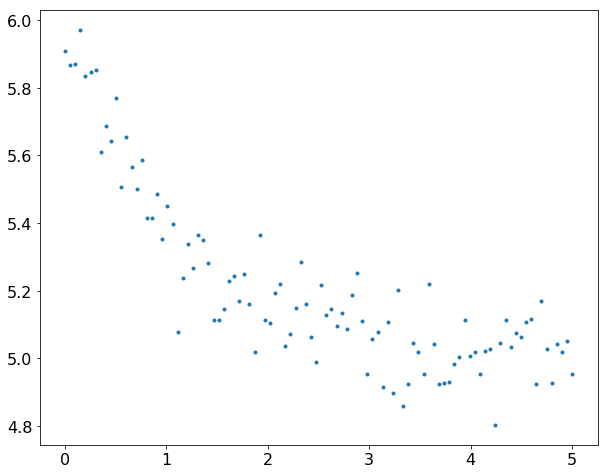

In [6]:
a = -1
b = 5

x = np.linspace(0, 5, 100)
y = np.exp(a * x) + b + np.random.normal(0, 0.1, 100)

plt.plot(x, y, '.', label='data')

In [7]:
from scipy.optimize import curve_fit



def f(x, a, b):
    return np.exp(a * x) + b


params, covariance_matrix = curve_fit(f, x, y)

uncertainties = np.sqrt(np.diag(covariance_matrix))

print('a = {:5.2f} ± {:.2f}'.format(params[0], uncertainties[0]))
print('b = {:5.2f} ± {:.2f}'.format(params[1], uncertainties[1]))

a = -0.95 ± 0.08
b =  5.00 ± 0.02


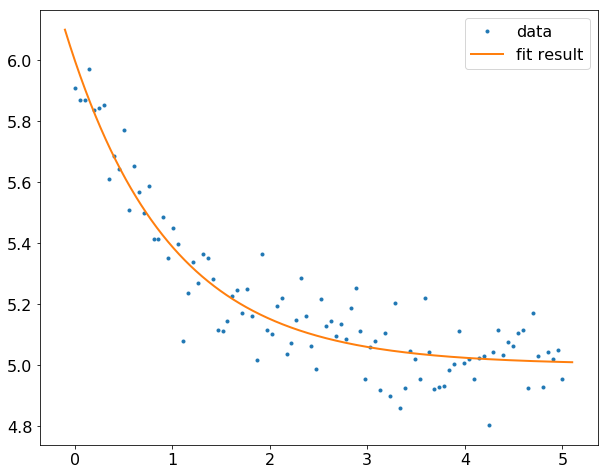

In [8]:
x_plot = np.linspace(-0.1, 5.1, 1000)

plt.plot(x, y, '.', label='data')
plt.plot(x_plot, f(x_plot, *params), label='fit result')
plt.legend();

<a id=uncertainties_guesses></a>
### Providing uncertainties and initial guesses

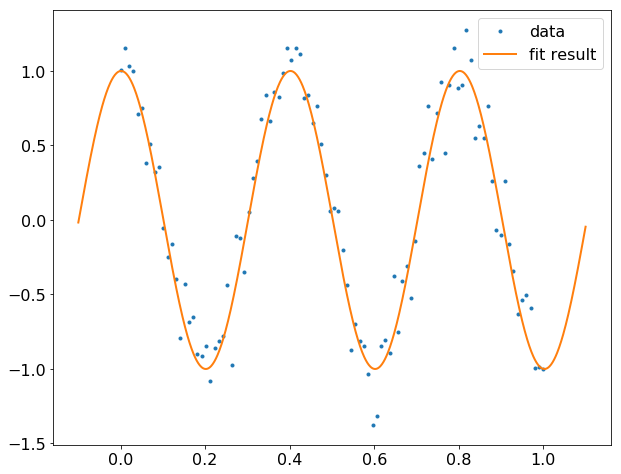

In [9]:
x = np.linspace(0, 1, 100)
y = np.sin(5 * np.pi * x + np.pi / 2) 
yerr = np.full_like(y, 0.2)

noise = np.random.normal(0, yerr, 100)

y += noise

def f(x, a, b):
    return np.sin(a * x + b)


#params, covariance_matrix = curve_fit(f, x, y)

# params, covariance_matrix = curve_fit(
#    f, x, y,
#    p0=[15, 2],
#)

params, covariance_matrix = curve_fit(
    f, x, y,
    p0=[15, 1.5],
    sigma=yerr,
    absolute_sigma=True,
)


# plot the stuff

x_plot = np.linspace(-0.1, 1.1, 1000)

plt.plot(x, y, '.', label='data')
plt.plot(x_plot, f(x_plot, *params), label='fit result')
plt.legend();

<a id=plot_corr_matrix></a>
### Plotting the correlation matrix

In [10]:
def cov2cor(cov):
    '''Convert the covariance matrix to the correlation matrix'''
    D = np.diag(1 / np.sqrt(np.diag(cov)))
    return D @ cov @ D

In [11]:
covariance_matrix

array([[ 0.00989379, -0.00496643],
       [-0.00496643,  0.00329989]])

array([[ 1.        , -0.86918806],
       [-0.86918806,  1.        ]])

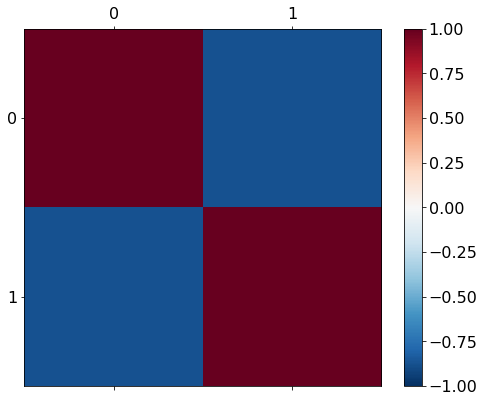

In [12]:
correlation_matrix = cov2cor(covariance_matrix)

plt.matshow(correlation_matrix, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar(shrink=0.8);

correlation_matrix

<a id=minimize></a>
## Unbinned likelihood fits using `minimize`

Simple example: an unbinned negative log-likelihood fit for a poissonian distribution

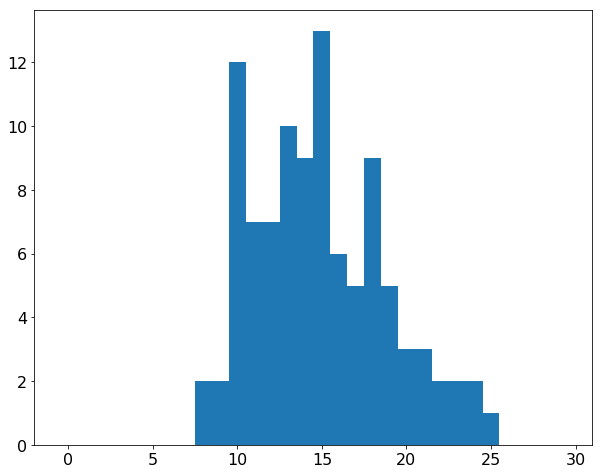

In [13]:
lambda_ = 15
k = np.random.poisson(lambda_, 100)

# make sure to use bins of integer width, centered around the integer
bin_edges = np.arange(0, 31) - 0.5

plt.hist(k, bins=bin_edges);

Poisson pdf:

$$ 
f(k, \lambda) = \frac{\lambda^k}{k!} \mathrm{e}^{-\lambda}
$$

So the likelihood is:

$$
\mathcal{L} = \prod_{i=0}^{N} \frac{\lambda^{k_i}}{k_i!} \mathrm{e}^{-\lambda}
$$

It's often easier to minimize $-\log(\mathcal{L})$, let's see:

$$
-\log(\mathcal{L}) = - \sum_{i=0}^{N}\bigl( k_i \log(\lambda) - \log{k_i!} - \lambda \bigr)
$$

We are interested in the minimum reletive to $\lambda$, so we dismiss constant term concerning $\lambda$ 
$$
-\log(\mathcal{L}) = \sum_{i=0}^{N}\bigl( \lambda - k_i \log(\lambda) \bigr)   
$$

This looks indeed easier to minimize than the likelihood.

In [14]:
from scipy.optimize import minimize

def negative_log_likelihood(lambda_, k):
    return np.sum(lambda_ - k * np.log(lambda_))

result = minimize(
    negative_log_likelihood,
    x0=(10, ),   # initial guess
    args=(k, ),  # additional arguments for the function to minimize
)

result

print('True λ = {}'.format(lambda_))
print('Fit: λ = {:.2f} ± {:.2f}'.format(result.x[0], np.sqrt(result.hess_inv[0, 0])))

True λ = 15
Fit: λ = 14.90 ± 0.39


* minimize has lots of options for different minimization algorithms
* Also able to respect bounds and constraints (with certain algorithms)
* It is worth to write down you problems and simplify the (log)Likelihood as much as possible

<a id=minimize_complex></a>
### A more complicated example

Fitting a gaussian with an exponential background 

Let's say we have two distributions, an exponential and a gaussian:

$$
f(x, \mu, \sigma, \tau, p) =  p \cdot \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x - \mu)^2}{\sigma^2}} + (1 - p) \cdot \frac{1}{\tau} \mathrm{e}^{- x / \tau}
$$

Likelihood:
$$
\mathcal{L} = \prod_{i = 0}^N \bigl( p \cdot \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x_i - \mu)^2}{\sigma^2}} + (1 - p) \cdot \frac{1}{\tau} \mathrm{e}^{- x_i / \tau} \bigr)
$$
Negative log-likelihood:

$$
-\log(\mathcal{L}) = -\sum_{i = 0}^N \log\bigl( p \cdot \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x_i - \mu)^2}{\sigma^2}} + (1 - p) \cdot \frac{1}{\tau} \mathrm{e}^{- x_i / \tau} \bigr)
$$

But we can make use of the built in scipy distributions:

<4x4 LbfgsInvHessProduct with dtype=float64>


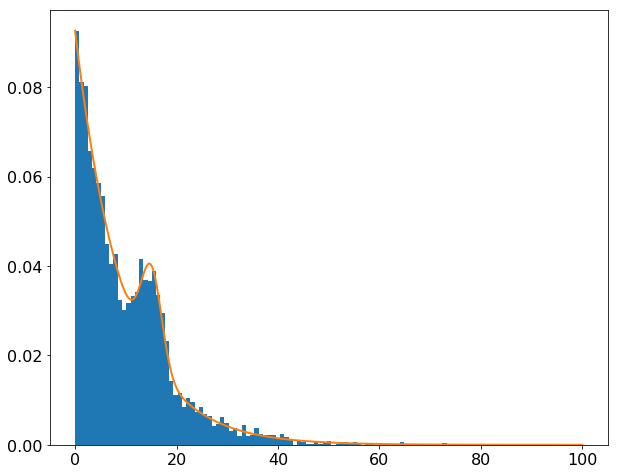

In [15]:
from scipy.stats import norm, expon

x = np.append(
    norm.rvs(loc=15, scale=2, size=500), 
    expon.rvs(scale=10, size=4500),
)

def pdf(x, mu, sigma, tau, p):
    return p*norm.pdf(x, mu, sigma) + (1 - p)*expon.pdf(x, scale=tau)


def negative_log_likelihood(params, x):
    mu, sigma, tau, p = params
    neg_l = -np.sum(np.log(pdf(x, mu, sigma, tau, p)))
    return neg_l


result = minimize(
    negative_log_likelihood,
    x0=(12, 1.5, 8, 0.2),   # initial guess
    args=(x, ),            # additional arguments for the function to minimize
    bounds=[
        (None, None),      # no bounds for mu
        (1e-32, None),         # sigma > 0
        (1e-32, None),         # tau > 0
        (0, 1),            # 0 <= p <= 1
    ],
    method='L-BFGS-B', # method that supports bounds
)

x_plot = np.linspace(0, 100, 1000)

plt.hist(x, bins=100, normed=True)
plt.plot(x_plot, pdf(x_plot, *result.x))

print(result.hess_inv)

[[ 1.         -0.37099423 -0.47113187 -0.68501647]
 [-0.37099423  1.         -0.53979934 -0.16810202]
 [-0.47113187 -0.53979934  1.          0.87576342]
 [-0.68501647 -0.16810202  0.87576342  1.        ]]


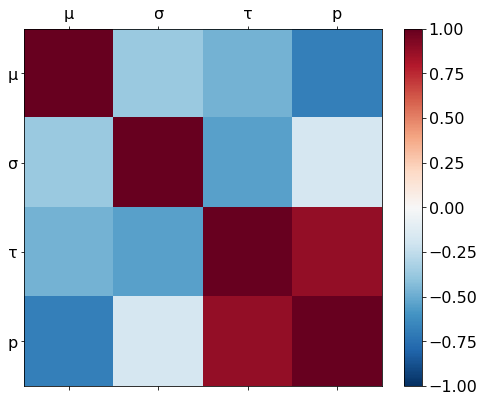

In [16]:
# get the covariance matrix as normal numpy array
covariance_matrix = result.hess_inv.todense()


correlation_matrix = cov2cor(covariance_matrix)

plt.matshow(correlation_matrix, vmin=-1, vmax=1, cmap='RdBu_r')

plt.colorbar(shrink=0.8);
plt.xticks(np.arange(4), ['μ', 'σ', 'τ', 'p'])
plt.yticks(np.arange(4), ['μ', 'σ', 'τ', 'p'])
print(correlation_matrix)

<a id=odr></a>
## Fitting data with x and y errors using `scipy.odr`

Most fitting routines only handle uncertainties on dependent variable (y-coordinate), and in most cases this is fine.
However, sometimes you may also want to consider errors on the independent variable (x-coordinate). This generally occurs
when you have some (non-negligible) uncertainty associated with your measurement apparatus.

Consider the following random data set with both x and y uncertainties:

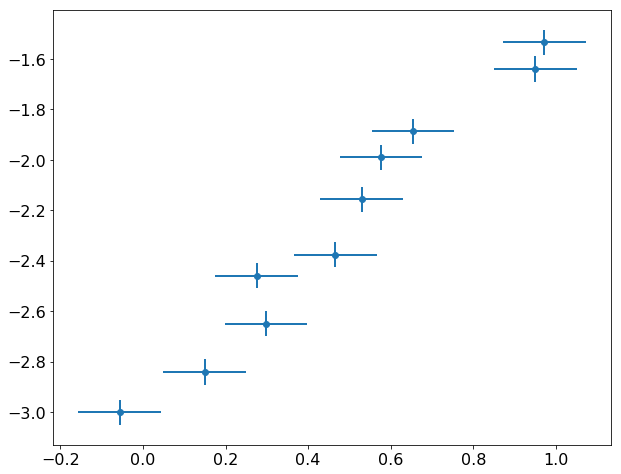

In [17]:
import numpy as np

# generate some data
real_values = np.array([1.5, -3])
x = np.linspace(0, 1, 10)
y = real_values[0]*x + real_values[1]
xerr = np.full_like(x, 0.1)
yerr = np.full_like(y, 0.05)

# add noise to the data
x += np.random.normal(0, xerr, 10)
y += np.random.normal(0, yerr, 10)

# plot the data
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o');

Cases like these can be handled using orthogonal distance regression (ODR). When the independent variable is error-free (or the errors are negligibly small), the residuals are computed as the *vertical* distance between the data points and the fit. This is the ordinary least-squares method.

In the specific case that the x and y uncertainties are equal, which would occur if the same measurement device is used to measure both the independent and dependent variables, the residual to be minimized will actually be *perpendicular* (orthogonal) to the fit curve. Note that Python's ODR fit routines do not require that the x and y uncertainties are equal.

Beta: [ 1.53224803 -2.9915801 ]
Beta Std Error: [ 0.10517528  0.06010705]
Beta Covariance: [[ 0.02740838 -0.01319663]
 [-0.01319663  0.00895173]]
Residual Variance: 0.4035933416579292
Inverse Condition #: 0.08830425649338726
Reason(s) for Halting:
  Sum of squares convergence


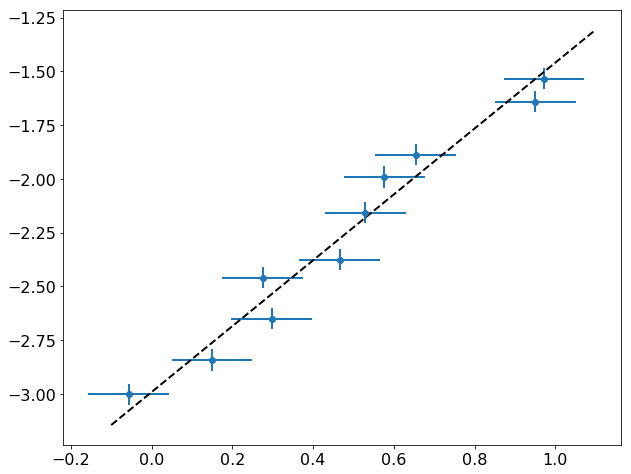

In [18]:
import scipy.odr as odr

# function we want to fit (in this case, a line)
def f(B, x):
    return B[0]*x + B[1]

# do the fit!
guess = [5, 0]
linear = odr.Model(f)
data = odr.RealData(x, y, sx=xerr, sy=yerr)
odr_fit = odr.ODR(data, linear, beta0=guess)
odr_output = odr_fit.run()
odr_output.pprint()   # pprint = 'pretty print' function

# plot data and ODR fit
z = np.linspace(-0.1, 1.1, 100)
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o')
plt.plot(z, f(odr_output.beta, z), 'k--');

Finally, we do a comparison to a fit with ordinary least-squares (curve_fit).

ODR Fit Results:   [ 1.53224803 -2.9915801 ]
curve_fit Results: [ 1.48161161 -2.9671998 ]
Real Values: [ 1.5 -3. ]


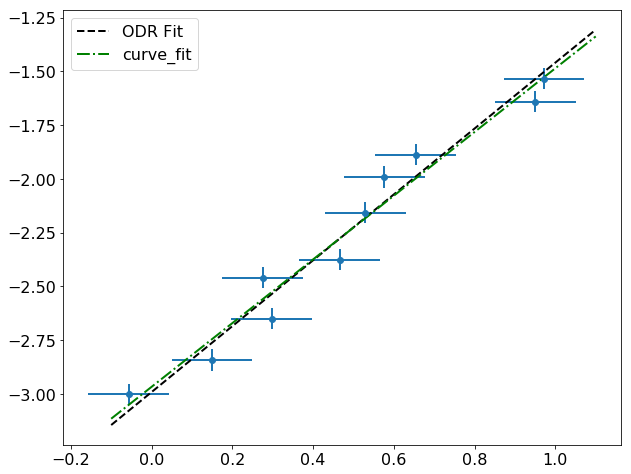

In [19]:
from scipy.optimize import curve_fit

def g(x, m, b):
    return m*x + b

params, covariance_matrix = curve_fit(g, x, y, sigma=yerr, p0=guess)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o')
plt.plot(z, f(odr_output.beta, z), 'k--', label='ODR Fit')
plt.plot(z, g(z, *params), 'g-.', label='curve_fit')
plt.legend(loc='best')

print('ODR Fit Results:  ', odr_output.beta)
print('curve_fit Results:', params)
print('Real Values:', real_values)

If the x-uncertainties are relatively small, in general curve_fit will produce a better result. However, if the uncertainties on the independent variable are large and/or there is a rapidly changing region of your curve where the x-errors are important, ODR fitting may produce a better result.

<a id=fft></a>
# Fast Fourier Transforms (FFTs)

In [20]:
freq1 = 5
freq2 = 50

t = np.linspace(0, 1, 1024*10)
y = np.sin(2*np.pi*freq1*t) + np.sin(2*np.pi*freq2*t)

# add some white noise
y += np.random.normal(y, 5)

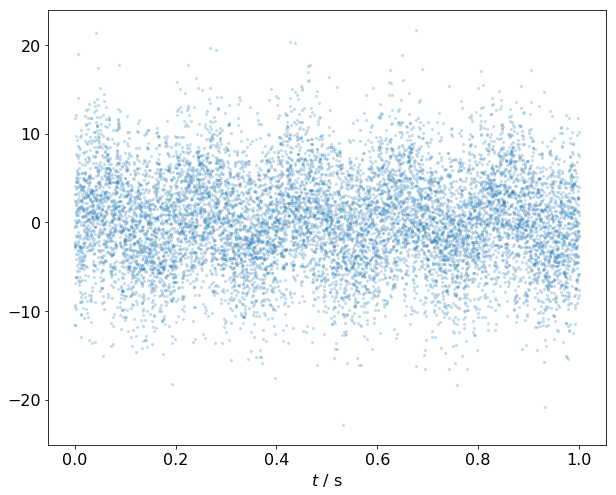

In [21]:
plt.scatter(t, y, s=10, alpha=0.25, lw=0)
plt.xlabel(r'$t \ /\ \mathrm{s}$');

In [22]:
from scipy import fftpack

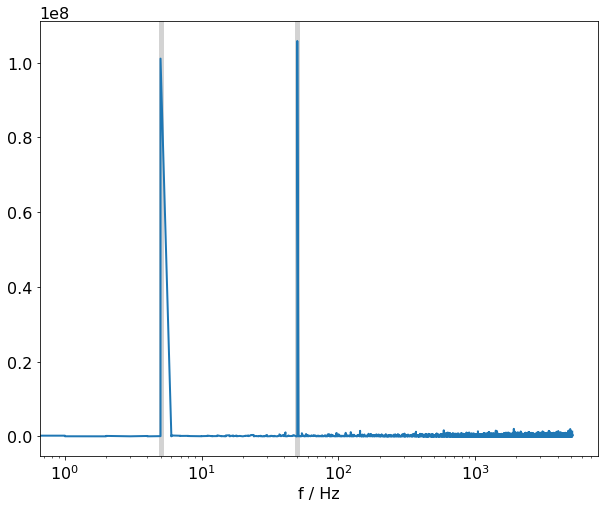

In [23]:
z = fftpack.rfft(y)
f = fftpack.rfftfreq(len(t), t[1] - t[0])

plt.axvline(freq1, color='lightgray', lw=5)
plt.axvline(freq2, color='lightgray', lw=5)

plt.plot(f, np.abs(z)**2)

plt.xlabel('f / Hz')
plt.xscale('log')
# plt.yscale('log');

<a id=filtering></a>
# Signal filtering

Consider this noisy data set with outliers. The data is a so-called S-curve, and we want to identify the midpoint of the falling edge.

Real value: 3
Fit value: 3.45009778787


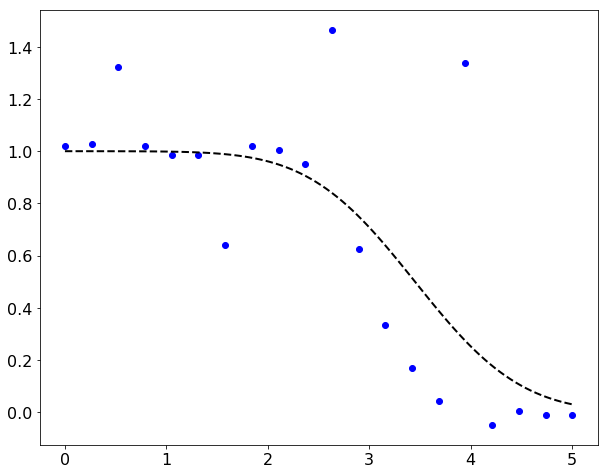

In [24]:
from scipy.special import ndtr

def s_curve(x, a, b):
    return ndtr(-a*(x - b))

# generate mildly noisy data using Gaussian CDF (see end of this notebook)
real_params = [2.5, 3]
x = np.linspace(0, 5, 20)
y = s_curve(x, *real_params)
y += np.random.normal(0, 0.025, len(y))

# add 4 bad data points
outlier_xcoords = [2, 6, 10, 15]
y[outlier_xcoords] = np.random.uniform(0.2, 2, size=4)
plt.plot(x, y, 'bo')

# attempt to fit
params, __ = curve_fit(s_curve, x, y)
z = np.linspace(0, 5, 100)
plt.plot(z, s_curve(z, *params), 'k--')
print('Real value:', real_params[1])
print('Fit value:', params[1])

You can see clearly in the data that the mid-point of the S-curve is at about x=3 (which is the real value), but the outliers destroy the fit. We can remove them easily with a median filter. A median filter is particularly suited to edge detection cases, since it tends to preserve edges well.

Real value: 3
Fit value: 3.05204333022


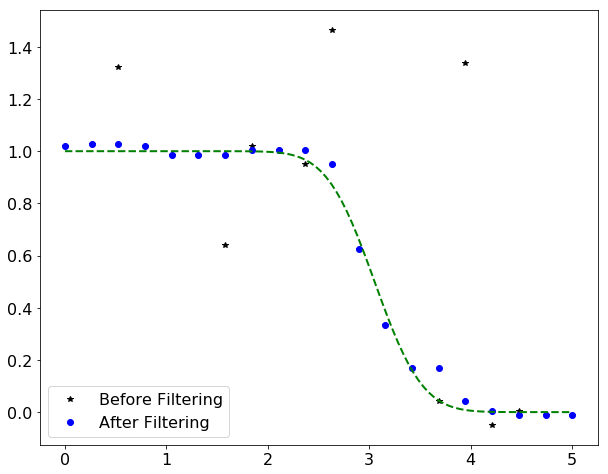

In [25]:
from scipy.signal import medfilt

filtered_y = medfilt(y)

params, __ = curve_fit(s_curve, x, filtered_y)
print('Real value:', real_params[1])
print('Fit value:', params[1])

z = np.linspace(0, 5, 100)
plt.plot(x, y, 'k*', label='Before Filtering')
plt.plot(x, filtered_y, 'bo', label='After Filtering')
plt.plot(z, s_curve(z, *params), 'g--')
plt.legend();

## Exercise

The following is an example implementation of a low-pass [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter):

In [26]:
from scipy.signal import butter, lfilter

def lowpass_filter(data, cutoff, fs, order=5):
    """
    Digital Butterworth low-pass filter.
    
    data   : 1D array of data to be filtered
    cutoff : cutoff frequency in Hz
    fs     : sampling frequency (samples/second)
    """
    nyquist_frequency = fs/2
    normal_cutoff = cutoff/nyquist_frequency
    b, a = butter(order, normal_cutoff, btype='low')
    y = lfilter(b, a, data)
    return y

You are the unfortunate recipient of the following noisy data, which contains noise at two different (unknown) frequencies:

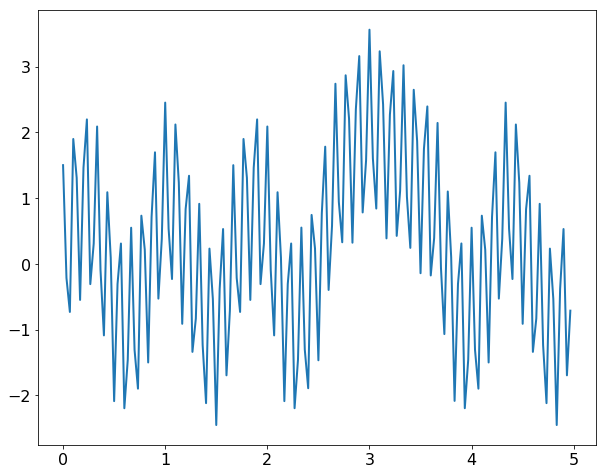

In [27]:
data = np.genfromtxt('../resources/scipy_filter_data.dat')
t = data[:, 0]
y = data[:, 1]
sample_freq = (len(t) - 1)/(t[-1])
plt.plot(t, y);   # these are your data

Somewhere in this mess is a Gaussian:

In [28]:
from scipy.stats import norm

def gaussian(x, mu, sigma, A):
    return A * norm.pdf(x, mu, sigma)

Use a FFT to identify the two offending noise frequencies. Then convert the `lowpass_filter` above into a bandstop filter (hint: it is a trivial modification), and remove the offending noise from the data as much as possible (it won't be perfect). Finally, use `curvefit` to fit a Gaussian to the data, thereby recovering the original signal.

<a id=integration></a>
# Integration

Scipy integration routines are discussed in the [Scipy documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html). We will look at the two most common routines here.

<a id=function_integration></a>
## Function integration

`quad` is used to evaluate definite 1D numerical integrals. For example, assume we want to integrate a quadratic polynomial $f(x) = 3x^2 + 6x - 9$ over an interval $x \in [0, 5]$. Analytically, the answer is:

$$ \int_0^5 3x^2 + 6x - 9 \ dx = \left[ x^3 + 3x^2 - 9x \right]_{x = 0}^{x = 5} = 155 $$

In [29]:
from scipy.integrate import quad

def f(x):
    return 3*x**2 + 6*x - 9

quad(f, 0, 5)

(155.0, 1.832332444897697e-12)

The first parameter `quad` returns is the answer; the second is an estimate of the absolute error in the result.

For 2D, 3D, or n-dimensional integrals , use `dblquad`, `tplquad`, or `nquad`, respectively.

For some more interesting functions, Scipy's other function integration routines might be helpful:
* `quadrature` : [Gaussian quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature)
* `romberg` : [Romberg integration](https://en.wikipedia.org/wiki/Romberg%27s_method)

For example, consider the $\mathrm{sinc}$ function:

$$
\mathrm{sinc}(x) \equiv
\begin{cases} 
1 & x = 0 \\
\sin(x)/x & \mathrm{otherwise}
\end{cases}
$$

/home/maxnoe/.local/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home/maxnoe/.local/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


(nan, nan)
(0.9797763423077573, 8.02804156349741e-09)


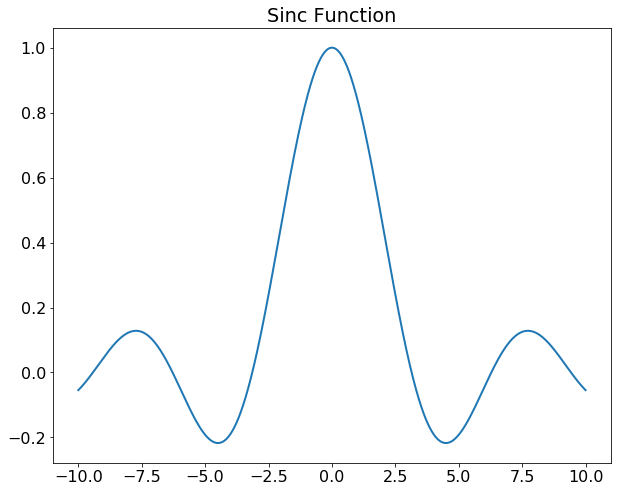

In [30]:
def sinc(x):
    return np.sin(x) / x


x = np.linspace(-10, 10, 1000)
y = sinc(x)
plt.plot(x, y)
plt.title('Sinc Function')

print(quad(sinc, -10, 10))   # fails

# numpys sinc handles the singularity correctly
print(quad(np.sinc, -10, 10))

`quad` struggles with $\mathrm{sinc}$, but it can be easily handled with Gaussian quadrature:

In [31]:
from scipy.integrate import quadrature

# quadrature may complain, but it will work in the end
print(quadrature(sinc, -10, 10)[0])

3.31669518844


/home/maxnoe/.local/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/maxnoe/.local/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = nan
  AccuracyWarning)


This result agrees with Mathematica to 13 decimal places (even though only 11 are shown). Note that the problem is the singularity at $x=0$; if we change the boundaries to, say, [-10.1, 10], then it works fine. Also, writing our sinc function more cleverly would eliminate the problem.

<a id=sampleintegration></a>
## Sample integration

If you have a collection of points that you want to integrate, you could use an [interpolation function](#interpolation) and pass it to `quad`. A better alternative is to use the purpose-built functions `trapz`, `romb`, and `simps`.

We will consider the $\mathrm{sinc}$ function again as an example. The most naive (and surprisingly robust) integration method is using the trapazoid rule, which is implemented in `trapz`:

In [32]:
from scipy.integrate import trapz

# 50 grid points
x = np.linspace(-10, 10)
y = sinc(x)
print('  50 points:', trapz(y, x))   # note the order of the arguments: y, x

# 1000 grid points
x = np.linspace(-10, 10, 1000)
y = sinc(x)
print('1000 points:', trapz(y, x))

  50 points: 3.31451159774
1000 points: 3.3166899468


<a id=interpolation></a>
# Interpolation

<a id=linear_interpolation></a>
## Linear interpolation

Imagine you would like to interpolate between two points $(x_0, y_0)$ and $(x_1, y_1)$. You could do this by hand:

$$y(x) = y_0 + (x - x_0) \frac{y_1 - y_0}{x_1 - x_0}$$

Simple enough, but it is annoying to look up or derive the formula. Also, what if you want values less than $x_0$ to stay at the value of $y_0$, and likewise for values greater than $x_1$? Then you need to add `if` statements, and check the logic, etc. Too much work.

Instead, there is a simple function for almost all of your interpolation needs: `interp1d`.

In [33]:
from scipy.interpolate import interp1d

x = (1, 2)
y = (5, 7)
print('Points:', list(zip(x, y)))

f = interp1d(x, y)
z = [1.25, 1.5, 1.75]
print('Interpolation:', list(zip(z, f(z))))

Points: [(1, 5), (2, 7)]
Interpolation: [(1.25, 5.5), (1.5, 6.0), (1.75, 6.5)]


Right now, if you try to use an x-coordinate outside of the interval $[x_0, x_1]$, a `ValueError` will be raised:

In [34]:
# f(2.5)   # uncomment to run me

This is because we haven't told `interp1d` how we want to handle the boundaries. This is done using the `fill_value` keyword argument. There are a few options:

1. Set values outside of the interval $[x_0, x_1]$ to a float.
2. Set values $< x_0$ to `below` and values $> x_1$ to `above` by passing a tuple, `(below, above)`.
3. Extrapolate points outside the interval by passing `extrapolate`.

We also need to tell `interp1d` not to raise a `ValueError` by setting the `bounds_error` keyword to `False`.

In [35]:
z = [0.5, 1, 1.5, 2, 2.5]

f = interp1d(x, y, bounds_error=False, fill_value=0)
print("Option 1:", list(zip(z, f(z))))

f = interp1d(x, y, bounds_error=False, fill_value=y)   # fill with endpoint values
print("Option 2:", list(zip(z, f(z))))

f = interp1d(x, y, fill_value='extrapolate')   # bounds_error set to False automatically
print("Option 3:", list(zip(z, f(z))))

Option 1: [(0.5, 0.0), (1, 5.0), (1.5, 6.0), (2, 7.0), (2.5, 0.0)]
Option 2: [(0.5, 5.0), (1, 5.0), (1.5, 6.0), (2, 7.0), (2.5, 7.0)]
Option 3: [(0.5, 4.0), (1, 5.0), (1.5, 6.0), (2, 7.0), (2.5, 8.0)]


<a id=spline_interpolation></a>
## Cubic spline interpolation

[Cubic splines](http://mathworld.wolfram.com/CubicSpline.html) are what are most commonly used when you want to interpolate between points *smoothly*.

Cubic spline interpolation is so common, it has its own method, `CubicSpline`, which produces generally better results.

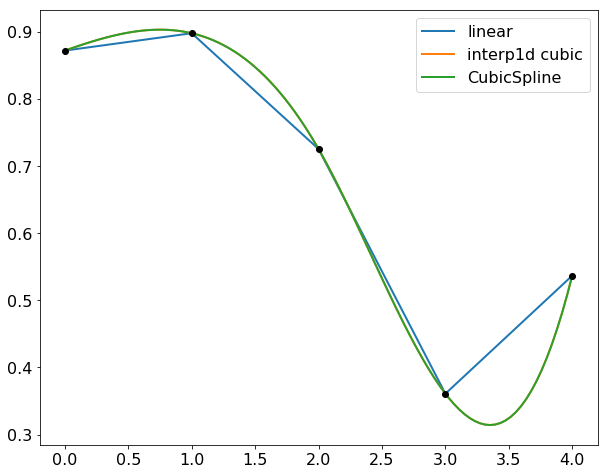

In [36]:
from scipy.interpolate import CubicSpline

npoints = 5
x = np.arange(npoints)
y = np.random.random(npoints)
plt.plot(x, y, label='linear')

f = interp1d(x, y, kind='cubic')
z = np.linspace(np.min(x), np.max(x), 100)
plt.plot(z, f(z), label='interp1d cubic')

f = CubicSpline(x, y)
z = np.linspace(np.min(x), np.max(x), 100)
plt.plot(z, f(z), label='CubicSpline')

plt.plot(x, y, 'ko')
plt.legend(loc='best');

<a id=special_functions></a>
# Special Functions

A complete list of scipy special functions can be found [here](https://docs.scipy.org/doc/scipy-0.14.0/reference/special.html).

<a id=bessel></a>
## Bessel functions

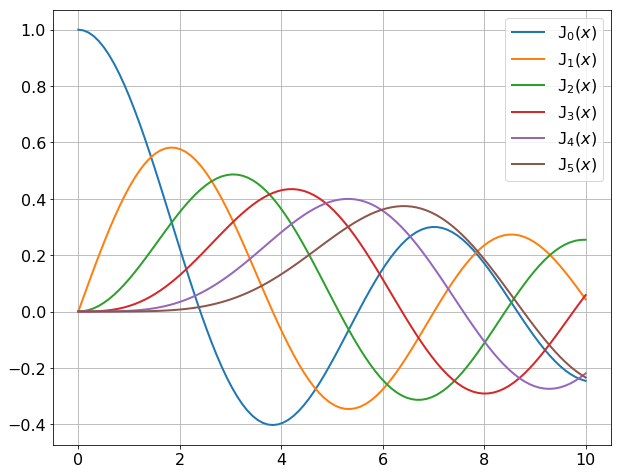

In [37]:
from scipy.special import jn

x = np.linspace(0, 10, 100)
for n in range(6):
    plt.plot(x, jn(n, x), label=r'$\mathtt{J}_{%i}(x)$' % n)
plt.grid()
plt.legend();

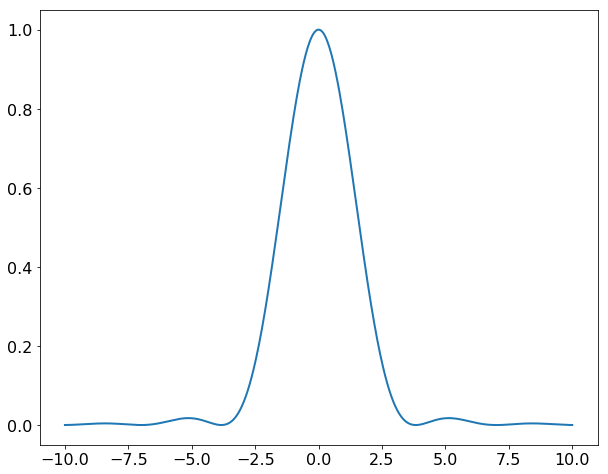

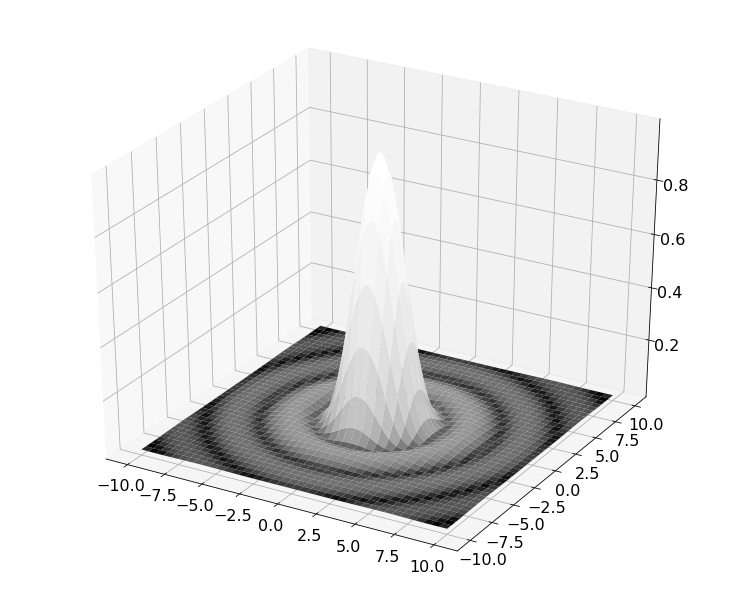

In [38]:
import mpl_toolkits.mplot3d.axes3d as plt3d
from matplotlib.colors import LogNorm

def airy_disk(x):
    mask = x != 0
    result = np.empty_like(x)
    result[~mask] = 1.0
    result[mask] = (2 * jn(1, x[mask]) / x[mask])**2
    return result

# 2D plot
r = np.linspace(-10, 10, 500)
plt.plot(r, airy_disk(r))

# 3D plot
x = np.arange(-10, 10.1, 0.1)
y = np.arange(-10, 10.1, 0.1)

X, Y = np.meshgrid(x, y)
Z = airy_disk(np.sqrt(X**2 + Y**2))

result
fig = plt.figure()
ax = plt3d.Axes3D(fig)
ax.plot_surface(X, Y, Z, cmap='gray', norm=LogNorm(), lw=0)

None

<a id=erf></a>
## Error function and Gaussian CDF

CDF = cumulative distribution function

$$\mathrm{erf}(z) = \frac{2}{\sqrt{\pi}} \int_0^z \exp\left( -t^2 \right) dt $$
$$\mathrm{ndtr}(z) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^z \exp\left( \frac{-t^2}{2} \right) dt $$

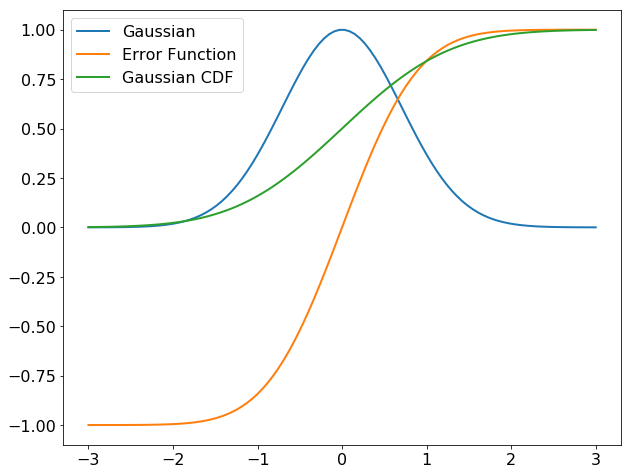

In [39]:
from scipy.special import erf, ndtr

def gaussian(z):
    return np.exp(-z**2)

x = np.linspace(-3, 3, 100)
plt.plot(x, gaussian(x), label='Gaussian')
plt.plot(x, erf(x), label='Error Function')
plt.plot(x, ndtr(x), label='Gaussian CDF')
plt.ylim(-1.1, 1.1)
plt.legend(loc='best');

<a id=ortho_polys></a>
## Orthogonal Polynomials

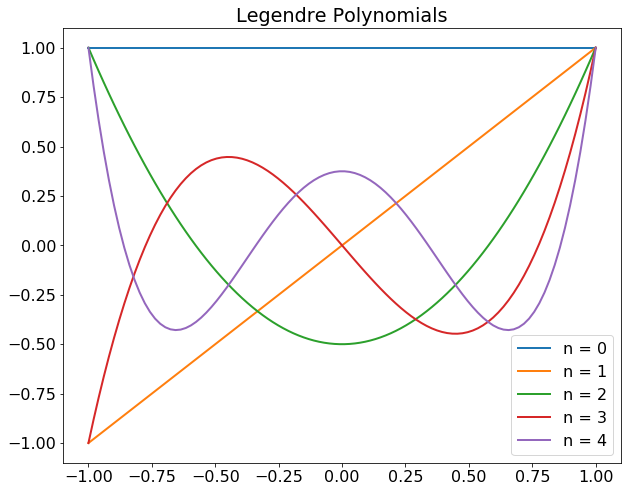

In [40]:
from scipy.special import eval_legendre, eval_laguerre, eval_hermite, eval_chebyt

ortho_poly_dict = {'Legendre': eval_legendre,
                   'Laguerre': eval_laguerre,
                   'Hermite': eval_hermite,
                   'Chebyshev T': eval_chebyt}

def plot_ortho_poly(name):
    plt.figure()
    f = ortho_poly_dict[name]
    x = np.linspace(-1, 1, 100)
    for n in range(5):
        plt.plot(x, f(n, x), label='n = %i' % n)
    if name is 'Legendre' or 'Chebyshev' in name:
        plt.ylim(-1.1, 1.1)
    plt.legend(loc='best', fontsize=16)
    plt.title(name + ' Polynomials')
    
plot_ortho_poly('Legendre')
# plot_ortho_poly('Laguerre')
# plot_ortho_poly('Hermite')
# plot_ortho_poly('Chebyshev T')

## Exercise

Orthogonal polynomials can be used to construct a series expansion of an arbitrary function, just like $\sin$ and $\cos$ are used to construct a Fourier series. For example, we can express a function $f(x)$ as a series of Legendre polynomials $P_n(x)$:

$$ f(x) = \sum_{n=0}^{\infty} a_n P_n(x) $$

The Legendre polynomials are orthogonal on the interval $x \in [-1, 1]$, where they obey the following orthogonality relationship:
$$ \int_{-1}^{1} P_n(x) \, P_m(x) \, dx = \frac{2}{2 m + 1} \delta_{mn} $$

With $f(x) = sin(\pi x)$, write a function to calculate the coefficients $a_n$ of the Legendre series. Then plot $f(x)$ and the Legendre series for $x \in [-1, 1]$. Calculate as many coefficients as are needed for the series to essentially the same as $f(x)$ (it will be less than ten).

If you are struggling with the math, look [here](http://mathworld.wolfram.com/Fourier-LegendreSeries.html).